# *Import Libary*

In [7]:
# %pip install tensorflowjs
%pip install scikit-image


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage import io, img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.transform import AffineTransform, warp, rotate
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import os
# from google.colab import drive, files
import shutil
from PIL import Image
from collections import Counter
import random
# import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tq
from sklearn.metrics import confusion_matrix, classification_report


# *Connect Google Drive*

In [9]:
# # Mount Google Drive
# drive.mount('/content/drive')

# *Upload kaggle API & Set up*

In [10]:
# # Upload file kaggle.json
# files.upload()

In [11]:
# # Buat folder ~/.kaggle jika belum ada
# os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# # Pindahkan file kaggle.json yang di-upload ke folder tersebut
# !cp kaggle.json ~/.kaggle/

# # Ubah permission
# !chmod 600 ~/.kaggle/kaggle.json

# *Download Dataset dan Simpan di Google Drive*

In [12]:
# # Slug dataset
# dataset_slug = 'agungmrf/indonesian-sign-language-bisindo'
# dataset_name = dataset_slug.split('/')[-1]

# # Path Drive tempat simpan dataset
# drive_path = f'/content/drive/MyDrive/datasets-capstone/{dataset_name}'
# zip_path = os.path.join(drive_path, f'{dataset_name}.zip')

# # File zip akan mengekstrak folder "plant_leaf_dataset'
# extract_path = os.path.join(drive_path, 'bisindo')

# # Buat folder penyimpanan jika belum ada
# os.makedirs(drive_path, exist_ok=True)

# # Download dan unzip hanya jika belum ada hasil ekstraknya
# if not os.path.exists(extract_path):
#     print("Mengunduh dari Kaggle...")
#     !kaggle datasets download -d {dataset_slug} -p "{drive_path}"

#     print("Mengekstrak dataset...")
#     !unzip -q "{zip_path}" -d "{drive_path}"
#     print("Dataset tersimpan di Google Drive.")
# else:
#     print("Dataset sudah tersedia di Google Drive.")

# """
# Sel ini tidak perlu dijalankan jika sebelumnya sudah pernah di jalankan
# """

# *Upload Dataset ke Lingkungan Colab*

# *Menampilkan Daftar Kelas*

# *Menampilkan Sample dari setiap Kelas*

In [39]:
# # Path dataset
# dataset_path = '/BISINDO_Dataset/bisindo'

# # Mnyimpan list nama gambar untuk setiap kelas
# letters_images = {}

# for class_name in os.listdir(dataset_path):
#     class_dir = os.path.join(dataset_path, class_name)
#     if os.path.isdir(class_dir):
#         letters_images[class_name] = os.listdir(class_dir)

# # Jumlah gambar yang ingin ditamplkan perkelas
# num_images = 5

# # Ukuran plot
# fig, axs = plt.subplots(len(letters_images), num_images, figsize=(num_images * 3, len(letters_images) * 3))

# for i, class_name in enumerate(sorted(letters_images.keys())):

#     images = np.random.choice(letters_images[class_name], num_images, replace=False)

#     for j, image_name in enumerate(images):
#         img_path = os.path.join(dataset_path, class_name, image_name)
#         img = Image.open(img_path).convert("RGB")

#         axs[i, j].imshow(img)
#         axs[i, j].set_xlabel(class_name if j == 0 else "")
#         axs[i, j].set_xticks([])
#         axs[i, j].set_yticks([])

# plt.tight_layout()
# plt.show()


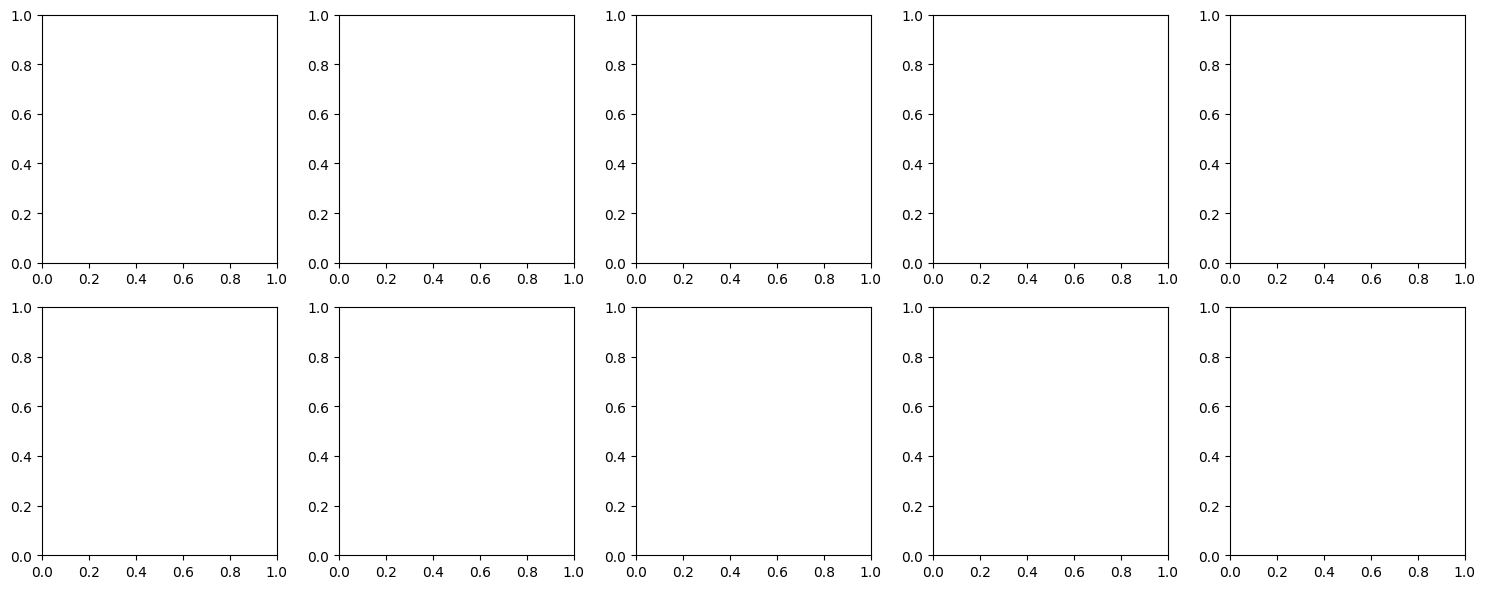

In [2]:
dataset_path = "BISINDO_Dataset/bisindo"
class_names = os.listdir(dataset_path)

fig, axs = plt.subplots(len(class_names), 5, figsize=(15, 3 * len(class_names)))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    
    if not os.path.isdir(class_path):
        continue  # Skip if not a directory

    # Get only image files
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for j, image_name in enumerate(images[:5]):  # Show up to 5 images
        img_path = os.path.join(class_path, image_name)
        img = Image.open(img_path).convert("RGB")
        axs[i, j].imshow(img)
        axs[i, j].set_xlabel(class_name if j == 0 else "")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.tight_layout()
plt.show()


# *Melihat Distribusi data seriap Kelas*

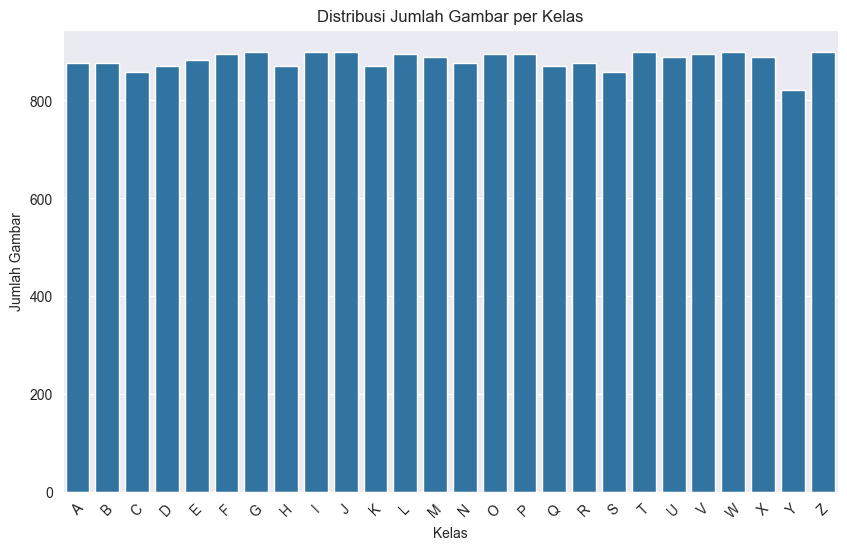

In [3]:
# List untuk simpan nama file, path lengkap, dan label kelas
file_name = []
labels = []
full_path = []

# Kumpulkan data
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

# Buat DataFrame
distribution_df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi jumlah gambar per kelas
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x='labels', order=sorted(distribution_df['labels'].unique()))
plt.title('Distribusi Jumlah Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.show()


In [4]:
labels = []

for path, subdirs, files in os.walk(dataset_path):
    label = os.path.basename(path)
    if files:
        labels.extend([label] * len(files))

# Hitung jumlah file tiap kelas
count_per_class = Counter(labels)

for kelas, jumlah in count_per_class.items():
    print(f"Kelas '{kelas}': {jumlah} file")

Kelas 'A': 876 file
Kelas 'B': 877 file
Kelas 'C': 858 file
Kelas 'D': 870 file
Kelas 'E': 882 file
Kelas 'F': 894 file
Kelas 'G': 900 file
Kelas 'H': 870 file
Kelas 'I': 900 file
Kelas 'J': 900 file
Kelas 'K': 870 file
Kelas 'L': 894 file
Kelas 'M': 888 file
Kelas 'N': 876 file
Kelas 'O': 894 file
Kelas 'P': 894 file
Kelas 'Q': 870 file
Kelas 'R': 876 file
Kelas 'S': 858 file
Kelas 'T': 900 file
Kelas 'U': 888 file
Kelas 'V': 894 file
Kelas 'W': 900 file
Kelas 'X': 888 file
Kelas 'Y': 822 file
Kelas 'Z': 900 file


# *Data Splitting (Run here)*

In [5]:
# Ambil path gambar, nama file, dan label
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))
            file_name.append(name)

# Buat dataframa
df = pd.DataFrame({'path': full_path, 'file_name': file_name, 'labels': labels})

In [6]:
# Split data menjadi train, valid, test (64%, 16%, 20%)
X = df['path']
y = df['labels']

# Split test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split valid (20% dari sisanya = 16% dari total)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Gabungkan ke DataFrame baru
df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_valid = pd.DataFrame({'path': X_valid, 'labels': y_valid, 'set': 'valid'})
df_test  = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

df_all = pd.concat([df_train, df_valid, df_test], ignore_index=True)

In [7]:
# Path akhir dataset
output_base = '/content/bisindo_final'

# Salin folder finalk
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    label = row['labels']
    split = row['set']
    src = row['path']
    dst_dir = os.path.join(output_base, split, label)
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, os.path.basename(src))
    if not os.path.exists(dst):
        shutil.copy2(src, dst)

  0%|          | 0/11470 [00:00<?, ?it/s]

100%|██████████| 11470/11470 [00:20<00:00, 554.22it/s]


In [8]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ------------------------------
# 1. Set Seed for Reproducibility
# ------------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# ------------------------------
# 2. Define Paths
# ------------------------------
TRAIN_DIR = '/content/bisindo_final/train'
VALID_DIR = '/content/bisindo_final/valid'
TEST_DIR = '/content/bisindo_final/test'

# ------------------------------
# 3. Data Augmentation
# ------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    horizontal_flip=False  # ubah ke True hanya jika arah tangan tidak penting
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# ------------------------------
# 4. Data Generators
# ------------------------------
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=1,  # tetap 1 jika ingin evaluasi/prediksi urut per gambar
    class_mode='categorical',
    shuffle=False
)

# ------------------------------
# 5. Cek Konsistensi Kelas
# ------------------------------
assert train_generator.class_indices == validation_generator.class_indices == test_generator.class_indices, \
    "❌ Class indices tidak konsisten antara train, valid, dan test! Pastikan semua folder punya subfolder kelas yang sama."

print("✅ Data generators siap digunakan.")


Found 7340 images belonging to 26 classes.
Found 1836 images belonging to 26 classes.
Found 2294 images belonging to 26 classes.
✅ Data generators siap digunakan.


# *Membangun Model*

# *Architecture*

In [9]:
model2 = Sequential([
    # Block 1
    Conv2D(32, (3,3), padding='same', input_shape=(150,150,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2,2),

    # Block 2
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2,2),

    # Block 3
    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2,2),

    # Block 4
    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(2,2),

    # Flatten
    Flatten(),

    # Dense Layers
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Output Layer
    Dense(26, activation='softmax')
])

c:\Users\asus\anaconda3\envs\main-ds\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# *Model compile & callbacks for architecture*

In [10]:
# MODEL COMPILATION

optimizer = Adam(learning_rate=0.0005)
model2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# CALLBACKS

callbacksM2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

# *Melatih Model*

In [49]:
# MODEL TRAINING

history = model2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=30,
    callbacks=callbacksM2,
)

# EVALUATION
print("\nEvaluating on test set...")
test_results = model2.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Precision: {test_results[2]*100:.2f}%")
print(f"Test Recall: {test_results[3]*100:.2f}%")

c:\Users\asus\anaconda3\envs\main-ds\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1346 - loss: 3.3889 - precision: 0.2785 - recall: 0.0204

230/230 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.1349 - loss: 3.3872 - precision: 0.2796 - recall: 0.0205 - val_accuracy: 0.0654 - val_loss: 4.7132 - val_precision: 0.1274 - val_recall: 0.0615
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3980 - loss: 2.1779 - precision: 0.7710 - recall: 0.1462

230/230 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.3981 - loss: 2.1774 - precision: 0.7711 - recall: 0.1464 - val_accuracy: 0.5899 - val_loss: 1.6826 - val_precision: 0.9950 - val_recall: 0.2173
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.5252 - loss: 1.7447 - precision: 0.8660 - recall: 0.2757 - val_accuracy: 0.4635 - val_loss: 1.7755 - val_precision: 0.6635 - val_recall: 0.3039
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5871 - loss: 1.5303 - precision: 0.8709 - recall: 0.3622

230/230 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.5871 - loss: 1.5301 - precision: 0.8710 - recall: 0.3623 - val_accuracy: 0.7565 - val_loss: 0.9377 - val_precision: 0.9737 - val_recall: 0.6661
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.6366 - loss: 1.3613 - precision: 0.8768 - recall: 0.4465 - val_accuracy: 0.7380 - val_loss: 0.9417 - val_precision: 0.9603 - val_recall: 0.6449
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6864 - loss: 1.1910 - precision: 0.8895 - recall: 0.5222

230/230 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.6864 - loss: 1.1910 - precision: 0.8895 - recall: 0.5223 - val_accuracy: 0.7680 - val_loss: 0.7499 - val_precision: 0.9463 - val_recall: 0.7010
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6978 - loss: 1.0905 - precision: 0.8934 - recall: 0.5610

230/230 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.6979 - loss: 1.0904 - precision: 0.8934 - recall: 0.5611 - val_accuracy: 0.8154 - val_loss: 0.6725 - val_precision: 0.9510 - val_recall: 0.7407
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7276 - loss: 0.9970 - precision: 0.9131 - recall: 0.6159

230/230 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.7276 - loss: 0.9969 - precision: 0.9130 - recall: 0.6159 - val_accuracy: 0.8322 - val_loss: 0.5493 - val_precision: 0.9599 - val_recall: 0.7565
Epoch 9/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.7446 - loss: 0.9255 - precision: 0.9158 - recall: 0.6316 - val_accuracy: 0.8115 - val_loss: 0.6800 - val_precision: 0.9529 - val_recall: 0.7375
Epoch 10/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.7459 - loss: 0.9356 - precision: 0.9027 - recall: 0.6483 - val_accuracy: 0.7571 - val_loss: 0.8306 - val_precision: 0.9317 - val_recall: 0.6536
Epoch 11/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.7652 - loss: 0.8449 - precision: 0.9104 - recall: 0.6737 - val_accuracy: 0.8007 - val_loss: 0.6099 - val_precision: 0.8965 - val_recall: 0.7217
Epoch 12/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7790 - loss: 0.7738 - precision: 0.9095 - recall: 0.6898

230/230 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.7790 - loss: 0.7738 - precision: 0.9095 - recall: 0.6898 - val_accuracy: 0.8546 - val_loss: 0.5291 - val_precision: 0.9518 - val_recall: 0.7854
Epoch 13/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.7797 - loss: 0.7895 - precision: 0.9118 - recall: 0.7049 - val_accuracy: 0.8273 - val_loss: 0.5290 - val_precision: 0.9056 - val_recall: 0.7685
Epoch 14/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.7937 - loss: 0.7380 - precision: 0.9103 - recall: 0.7147 - val_accuracy: 0.8404 - val_loss: 0.4726 - val_precision: 0.9335 - val_recall: 0.7947
Epoch 15/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7941 - loss: 0.7139 - precision: 0.9060 - recall: 0.7262

230/230 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.7941 - loss: 0.7138 - precision: 0.9060 - recall: 0.7262 - val_accuracy: 0.8780 - val_loss: 0.3842 - val_precision: 0.9525 - val_recall: 0.8295
Epoch 16/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.8039 - loss: 0.6816 - precision: 0.9117 - recall: 0.7404 - val_accuracy: 0.8698 - val_loss: 0.3782 - val_precision: 0.9220 - val_recall: 0.8241
Epoch 17/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.8078 - loss: 0.6551 - precision: 0.9129 - recall: 0.7468 - val_accuracy: 0.8638 - val_loss: 0.4186 - val_precision: 0.9201 - val_recall: 0.8279
Epoch 18/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8247 - loss: 0.6274 - precision: 0.9163 - recall: 0.7667

230/230 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.8247 - loss: 0.6274 - precision: 0.9162 - recall: 0.7667 - val_accuracy: 0.8878 - val_loss: 0.3529 - val_precision: 0.9501 - val_recall: 0.8399
Epoch 19/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.8339 - loss: 0.5645 - precision: 0.9167 - recall: 0.7789 - val_accuracy: 0.5741 - val_loss: 1.0689 - val_precision: 0.6699 - val_recall: 0.4853
Epoch 20/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.8292 - loss: 0.5854 - precision: 0.9148 - recall: 0.7780 - val_accuracy: 0.8143 - val_loss: 0.6115 - val_precision: 0.8686 - val_recall: 0.7631
Epoch 21/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.8383 - loss: 0.5596 - precision: 0.9137 - recall: 0.7907 - val_accuracy: 0.8753 - val_loss: 0.3769 - val_precision: 0.9402 - val_recall: 0.8393
Epoch 22/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.8579 - loss: 0.5129 - precision: 0.9248 - recall: 0.8081 - val_accuracy: 0.7702 - val_loss: 0.73

230/230 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.8407 - loss: 0.5278 - precision: 0.9074 - recall: 0.7962 - val_accuracy: 0.9178 - val_loss: 0.2581 - val_precision: 0.9661 - val_recall: 0.8834
Epoch 24/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.8553 - loss: 0.4794 - precision: 0.9245 - recall: 0.8172 - val_accuracy: 0.8731 - val_loss: 0.3609 - val_precision: 0.9195 - val_recall: 0.8393
Epoch 25/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.8557 - loss: 0.4965 - precision: 0.9186 - recall: 0.8178 - val_accuracy: 0.8845 - val_loss: 0.3581 - val_precision: 0.9313 - val_recall: 0.8562
Epoch 26/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.8559 - loss: 0.4863 - precision: 0.9135 - recall: 0.8133 - val_accuracy: 0.8480 - val_loss: 0.4276 - val_precision: 0.8910 - val_recall: 0.8192
Epoch 27/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.8626 - loss: 0.4468 - precision: 0.9238 - recall: 0.8272 - val_accuracy: 0.9145 - val_loss: 0.24

# *Visualisasi Loss dan Accuracy*

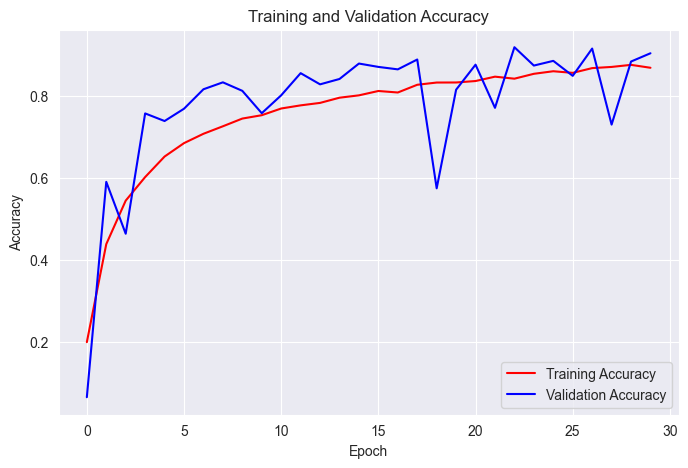

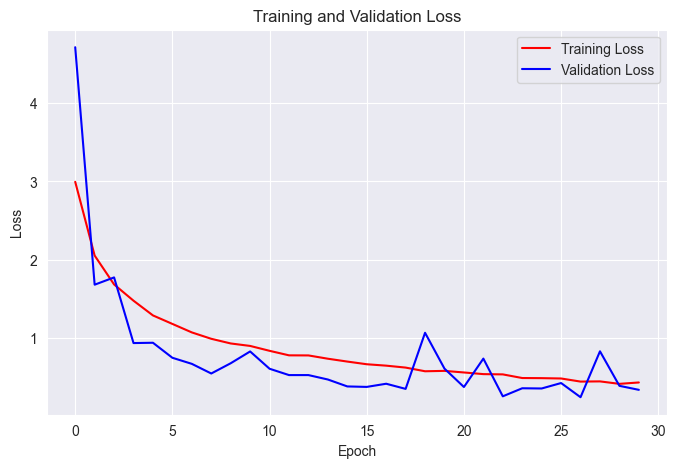

In [50]:
import matplotlib.pyplot as plt

# Ambil data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# *Evaluation*

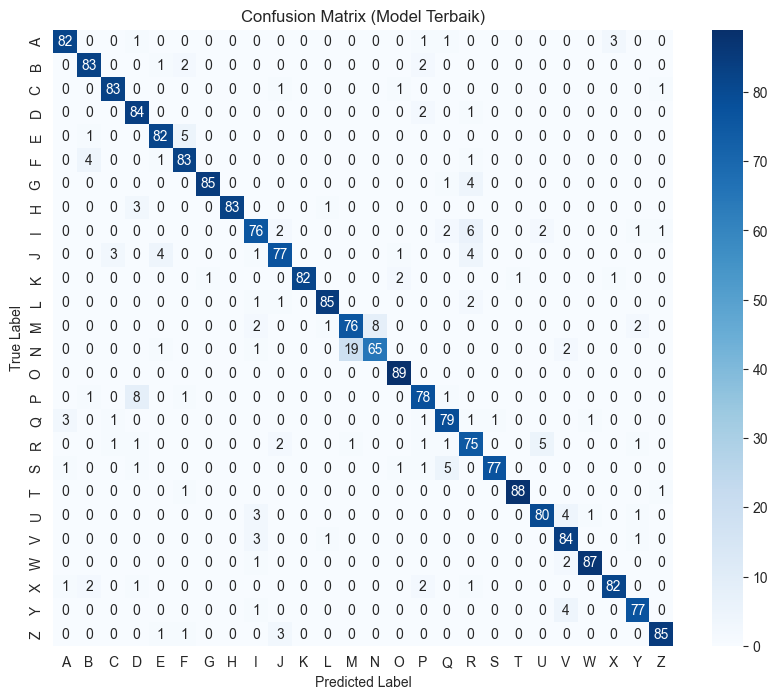


Classification Report (Model Terbaik):

              precision    recall  f1-score   support

           A     0.9425    0.9318    0.9371        88
           B     0.9121    0.9432    0.9274        88
           C     0.9432    0.9651    0.9540        86
           D     0.8485    0.9655    0.9032        87
           E     0.9111    0.9318    0.9213        88
           F     0.8925    0.9326    0.9121        89
           G     0.9884    0.9444    0.9659        90
           H     1.0000    0.9540    0.9765        87
           I     0.8539    0.8444    0.8492        90
           J     0.8953    0.8556    0.8750        90
           K     1.0000    0.9425    0.9704        87
           L     0.9659    0.9551    0.9605        89
           M     0.7917    0.8539    0.8216        89
           N     0.8904    0.7386    0.8075        88
           O     0.9468    1.0000    0.9727        89
           P     0.8864    0.8764    0.8814        89
           Q     0.8778    0.9080    0.8

In [51]:
# Asumsi Anda telah menyimpan model terbaik ke 'best_model.h5' selama pelatihan
best_model = load_model('best_model.h5')

# Reset generator sebelum prediksi
test_generator.reset()

# Prediksi probabilitas menggunakan model terbaik
preds = best_model.predict(test_generator, verbose=0)

# Ambil prediksi kelas (argmax)
predicted_classes = np.argmax(preds, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Buat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(cm, index=class_labels, columns=class_labels), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Model Terbaik)')
plt.show()

# Classification Report
print("\nClassification Report (Model Terbaik):\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

# *Simpan model dengan 3 format, TFLite, TFjs, dan SavedModel*

In [52]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    /content/tfjs_model

2025-05-27 13:16:44.358524: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 13:16:47.144641: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
c:\Users\asus\anaconda3\envs\main-ds\Lib\site-packages\tensorflowjs\read_weights.py:28: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.uint8, np.uint16, np.object, np.bool]
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\asus\anaconda3\envs\main-ds\Scri

In [ ]:
os.makedirs('tflite', exist_ok=True)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite = converter.convert()
tflite_path = 'tflite/model.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite)

Saved artifact at '/tmp/tmpdktbycnv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  139827245535632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139827245536400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139827226388688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139827226390224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139827245535056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139827245536784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139827226385424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139827226385616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139827226384656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139827226390992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139827226387920

In [ ]:
!zip -r saved_model.zip saved_model/
!zip -r tfjs_model.zip tfjs_model/
!zip -r tflite.zip tflite/

  adding: saved_model/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 71%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: saved_model/saved_model.pb (deflated 89%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 92%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tflite/ (stored 0%)
  adding: tflite/model.tflite (deflated 7%)


In [ ]:
from google.colab import files
files.download('tflite.zip')
files.download('saved_model.zip')
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# *Inference:*

## *Menggunakan best_modek*

In [ ]:
# Load Model
model = load_model('best_model.h5')

# Daftar Class
class_names = list(train_generator.class_indices.keys())

# 3. Fungsi Preprocessing
def preprocess_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# List Gambar yang Akan Diprediksi
image_paths = [
    '/content/Tebak1.png',
    '/content/Tebak2.png',
    '/content/Tebak3.png'
]

# Prediksi + Visualisasi
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(image_paths):
    # Preprocess
    processed_img = preprocess_image(img_path)

    # Prediksi
    pred = model.predict(processed_img)
    predicted_class = np.argmax(pred, axis=1)[0]
    predicted_label = class_names[predicted_class]
    confidence = np.max(pred) * 100

    # Tampilkan Gambar + Hasil
    plt.subplot(1, len(image_paths), i+1)
    img = image.load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%", pad=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

## *Menggunakan SavedModel*

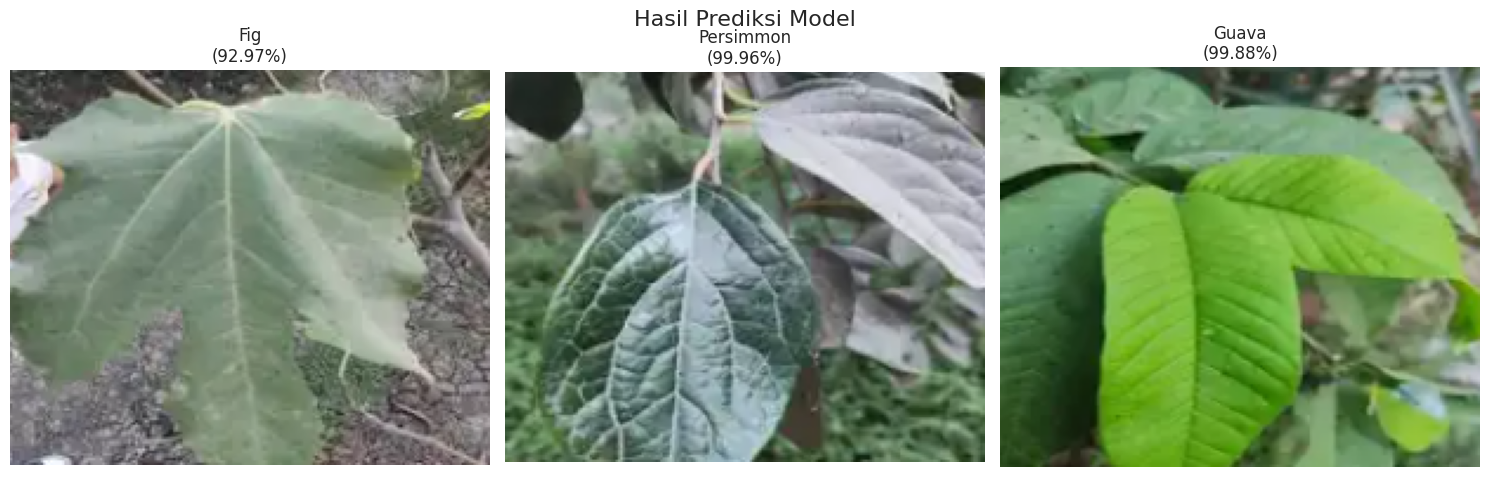

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load Model TFLite
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Get input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Daftar Class (sesuai training)
class_names = list(train_generator.class_indices.keys())

# Fungsi Preprocessing
def preprocess_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
    return img_array

# List Gambar yang Akan Diprediksi
image_paths = [
    '/content/Tebak1.png',
    '/content/Tebak2.png',
    '/content/Tebak3.png'
]

# Prediksi + Visualisasi
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(image_paths):
    # Preprocess
    img_array = preprocess_image(img_path)

    # Inference
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    # Post-processing
    predicted_class = np.argmax(output)
    predicted_label = class_names[predicted_class]
    confidence = np.max(output) * 100

    # Tampilkan Gambar + Hasil
    plt.subplot(1, 3, i+1)
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"{predicted_label}\n({confidence:.2f}%)", fontsize=12)
    plt.axis('off')

plt.suptitle("Hasil Prediksi Model", fontsize=16)
plt.tight_layout()
plt.show()